[*********************100%***********************]  1 of 1 completed


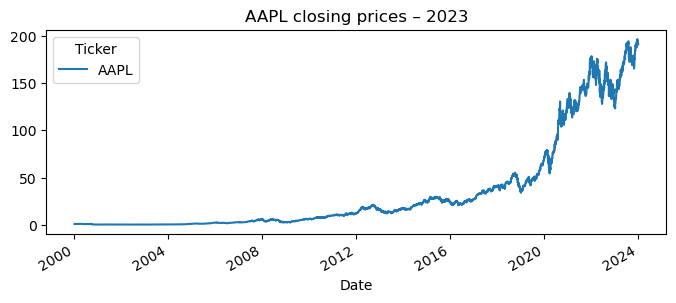

In [4]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

ticker = "AAPL"
prices = yf.download(ticker, start="2000-01-01", end="2023-12-31")["Close"].dropna()
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()


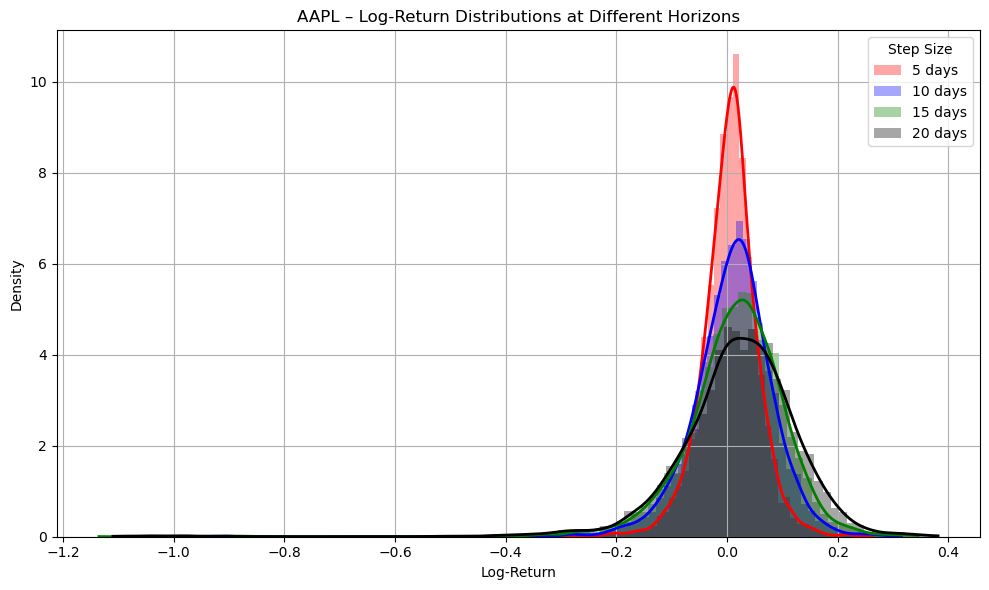

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

two_week_steps_list = [5, 10, 15, 20]  # trading-day lags
colors = ["red", "blue", "green", "black"]

plt.figure(figsize=(10, 6))

for i, step in enumerate(two_week_steps_list):
    # Compute log-returns at the given step size
    log_returns = np.log(prices / prices.shift(step)).dropna().values
    
    # Plot histogram (density normalized)
    plt.hist(
        log_returns,
        bins=100,
        density=True,
        color=colors[i],
        alpha=0.35,
        label=f"{step} days",
        edgecolor='none'
    )
    
    # Calculate KDE using scipy with correct shape
    kde = gaussian_kde(log_returns.reshape(1, -1))
    x_vals = np.linspace(log_returns.min(), log_returns.max(), 1000)
    plt.plot(x_vals, kde(x_vals), color=colors[i], linewidth=2)

plt.title(f"{ticker} – Log-Return Distributions at Different Horizons")
plt.xlabel("Log-Return")
plt.ylabel("Density")
plt.legend(title="Step Size")
plt.grid(True)
plt.tight_layout()
plt.show()


Initializing NUTS using jitter+adapt_diag...


2768 daily log-returns from 2013-01-02 to 2023-12-29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/cloud/miniconda3/envs/math-finance/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


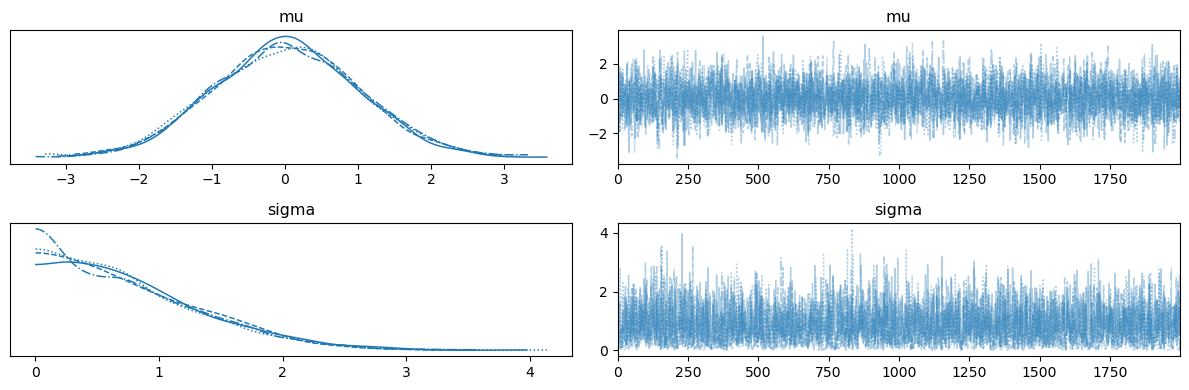

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0217,1.0065,-1.8095,1.9654,0.0170,0.0132,3520.6381,3304.5624,1.0005
sigma,0.7948,0.6071,0.0001,1.8844,0.0102,0.0068,2486.2405,2013.1332,1.0015


In [17]:
# --- 3. Transform to log-returns (the GBM observation) ---------------------
log_returns = np.diff(np.log(prices.values))              # r_t = ln(S_{t}/S_{t-1})
dt = 1/252

print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
      f"to {prices.index[-1].date()}")

with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=1)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=1)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = log_returnsgit 
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2000,
        tune          = 2000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


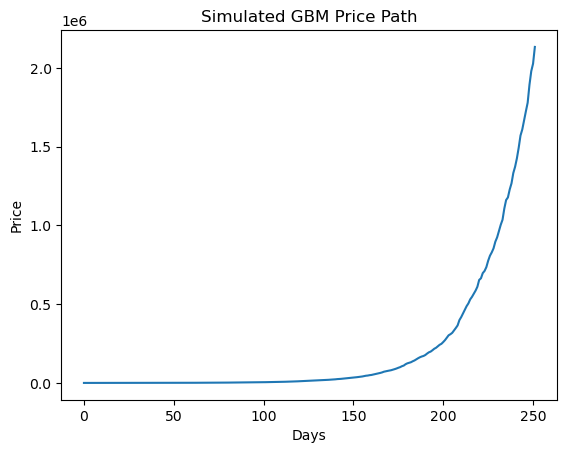

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


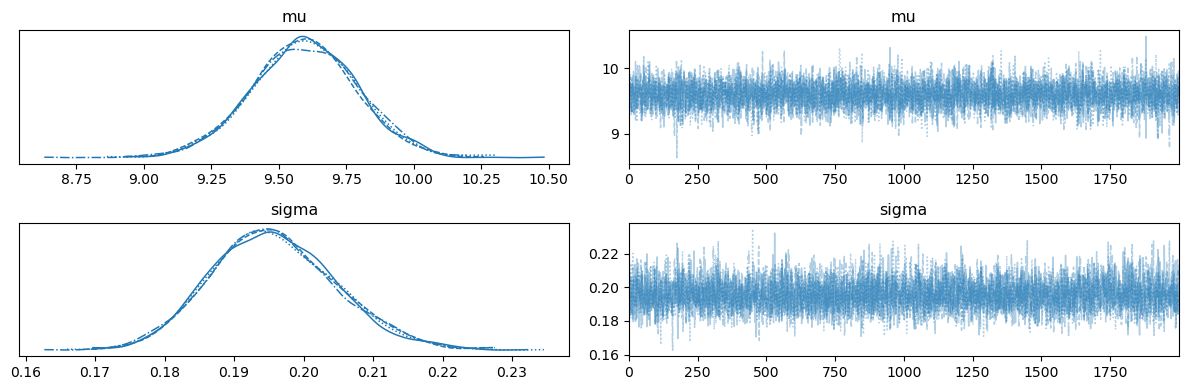


Posterior Summary:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     9.5958  0.1958  9.2284   9.9706     0.0027   0.0023  5447.0938   
sigma  0.1957  0.0090  0.1798   0.2133     0.0001   0.0001  4286.8528   

        ess_tail   r_hat  
mu     5182.1188  1.0001  
sigma  4223.4995  1.0011  

True mu = 10, True sigma = 0.2


In [9]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# --- Step 1: Simulate GBM path ---
np.random.seed(42)

T = 1.0        # 1 year
N = 252        # trading days
dt = T / N
mu_true = 10  # 10% drift
sigma_true = 0.2  # 20% annual volatility

# Simulate log-returns
log_returns_sim = (mu_true - 0.5 * sigma_true**2) * dt + sigma_true * np.sqrt(dt) * np.random.randn(N)
# Simulated price path
S0 = 100
prices_sim = S0 * np.exp(np.cumsum(log_returns_sim))

plt.plot(prices_sim)
plt.title("Simulated GBM Price Path")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

# --- Step 2: Inference from log-returns (like in real case) ---
with pm.Model() as model_sim:
    mu = pm.Normal("mu", mu=0.0, sigma=1.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    pm.Normal(
        "returns",
        mu=mu * dt,
        sigma=sigma * np.sqrt(dt),
        observed=log_returns_sim
    )

    trace_sim = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )

# --- Step 3: Results ---
az.plot_trace(trace_sim, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

print("\nPosterior Summary:")
print(az.summary(trace_sim, var_names=["mu", "sigma"], round_to=4))
print(f"\nTrue mu = {mu_true}, True sigma = {sigma_true}")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/cloud/miniconda3/envs/math-finance/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


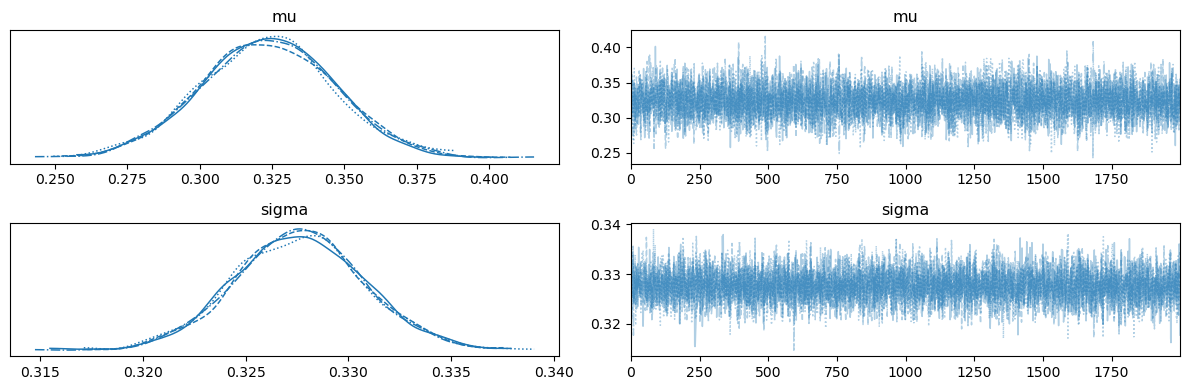

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.3234,0.0229,0.2785,0.3655,0.0003,0.0003,5808.9031,4872.9548,1.0001
sigma,0.3276,0.0031,0.3217,0.3336,0.0000,0.0000,5747.0215,5041.8039,1.0004


In [11]:
# --- 3. Transform to log-returns (the GBM observation) ---------------------

# dt = 1/26                                                # one trading day expressed in years
dt = 1/252


# Number of trading days in two weeks (approx 10; adjust if needed)
two_week_steps = 10
dt = two_week_steps/252

# Compute biweekly log-returns: r_t = ln(S_{t}/S_{t-10})
biweek_log_returns = np.log(prices / prices.shift(two_week_steps)).dropna().values

# print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
    #   f"to {prices.index[-1].date()}")

with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=10)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=10)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = biweek_log_returns
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2000,
        tune          = 2000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


In [ ]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(market_price, S, K, T, r, option_type='call'):
    def difference(sigma):
        bs_price = black_scholes_price(S, K, T, r, sigma, option_type)
        return bs_price - market_price

    result = brentq(difference, 1e-6, 5)
    return result

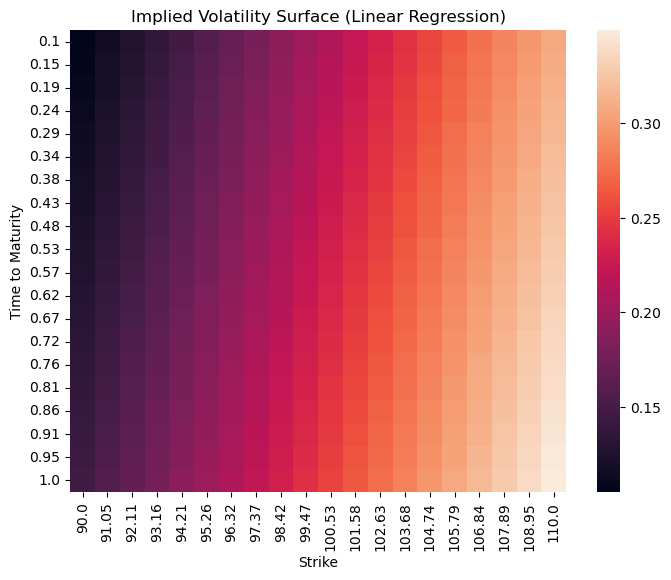

In [9]:
# Dummy data (replace with real market data)
np.random.seed(0)
K = np.linspace(90, 110, 20)
T = np.linspace(0.1, 1.0, 20)
K_grid, T_grid = np.meshgrid(K, T)
IV = 0.2 + 0.01 * (K_grid - 100) + 0.05 * T_grid + np.random.normal(0, 0.01, size=K_grid.shape)

X = np.column_stack([K_grid.ravel(), T_grid.ravel()])
y = IV.ravel()

reg = LinearRegression().fit(X, y)
IV_pred = reg.predict(X).reshape(K_grid.shape)

# Plot surface
plt.figure(figsize=(8,6))
sns.heatmap(IV_pred, xticklabels=np.round(K, 2), yticklabels=np.round(T, 2))
plt.title("Implied Volatility Surface (Linear Regression)")
plt.xlabel("Strike")
plt.ylabel("Time to Maturity")
plt.show()


In [11]:
import pymc as pm
import arviz as az

# Simulated option data
S = 100
K = 100
T = 0.5
r_true = 0.01
sigma_true = 0.2
observed_price = black_scholes_price(S, K, T, r_true, sigma_true)

with pm.Model() as model:
    sigma = pm.Uniform("sigma", 0.01, 1.0)
    r = pm.Uniform("r", 0.0, 0.1)
    
    theoretical_price = black_scholes_price(S, K, T, r, sigma)
    
    obs = pm.Normal("obs", mu=theoretical_price, sigma=1.0, observed=observed_price)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

az.plot_trace(trace, var_names=["sigma", "r"])
plt.show()


TypeError: TensorVariable cannot be converted to Python boolean. Call `.astype(bool)` for the symbolic equivalent.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


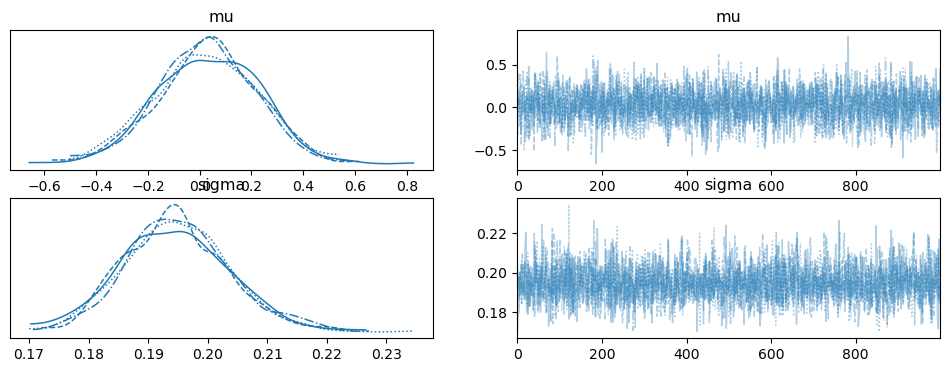

In [12]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Simulate GBM data (you can later replace this with real stock prices)
np.random.seed(42)
T = 1.0  # total time in years
N = 252  # number of time steps (e.g., trading days)
dt = T / N
mu_true = 0.05
sigma_true = 0.2

S0 = 100
returns = np.random.normal(mu_true * dt, sigma_true * np.sqrt(dt), size=N)
S = S0 * np.exp(np.cumsum(returns))

log_returns = np.diff(np.log(S))

# Bayesian Inference
with pm.Model() as gbm_model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    likelihood = pm.Normal("returns", mu=mu * dt, sigma=sigma * np.sqrt(dt), observed=log_returns)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

az.plot_trace(trace, var_names=["mu", "sigma"])
plt.show()


[*********************100%***********************]  1 of 1 completed


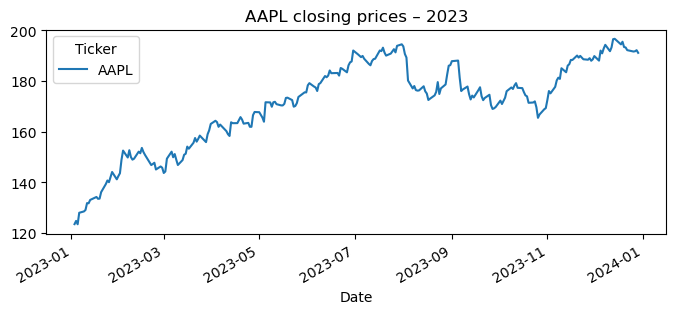

Initializing NUTS using jitter+adapt_diag...


250 daily log-returns from 2023-01-03 to 2023-12-29


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


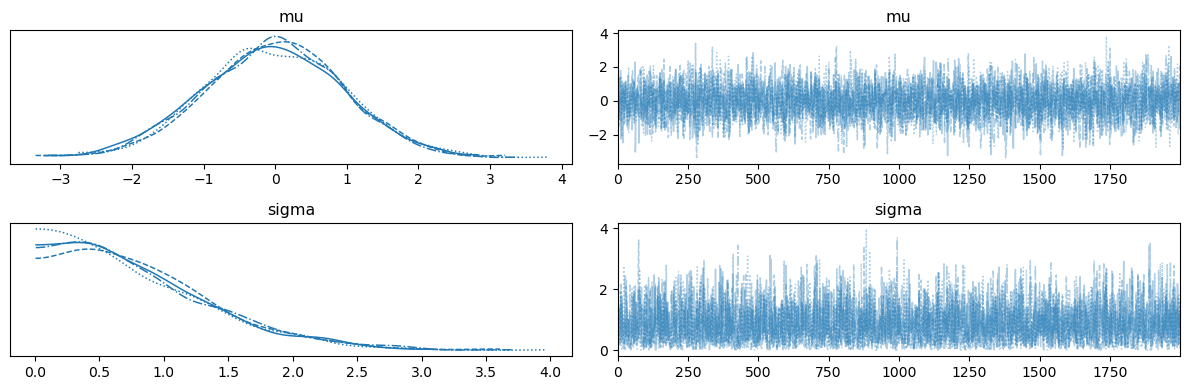

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.0197,0.9786,-1.8322,1.8461,0.0163,0.0126,3596.2035,3921.0559,1.0004
sigma,0.8047,0.5982,0.0001,1.9017,0.0096,0.0074,2794.7859,2320.6417,1.0025


In [13]:
# --- 1. Imports -------------------------------------------------------------
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# --- 2. Download daily closes for 2023 -------------------------------------
ticker = "AAPL"
prices = (
    yf.download(ticker, start="2023-01-01", end="2023-12-31")  # daily bars
      ["Close"]                                                # keep only Close column
      .dropna()
)
prices.plot(title=f"{ticker} closing prices – 2023", figsize=(8,3))
plt.show()

# --- 3. Transform to log-returns (the GBM observation) ---------------------
log_returns = np.diff(np.log(prices.values))              # r_t = ln(S_{t}/S_{t-1})
dt = 1/252                                                # one trading day expressed in years

print(f"{len(log_returns)} daily log-returns from {prices.index[0].date()} "
      f"to {prices.index[-1].date()}")

# --- 4. Bayesian inference with PyMC ---------------------------------------
with pm.Model() as gbm_model:
    # Priors – intentionally vague
    mu     = pm.Normal("mu", mu=0.0, sigma=1.0)           # drift  (per year)
    sigma  = pm.HalfNormal("sigma", sigma=1.0)            # volatility (per √year)

    # Likelihood – GBM says log-return ~ N(μ dt, σ² dt)
    pm.Normal(
        "returns",
        mu     = mu    * dt,
        sigma  = sigma * np.sqrt(dt),
        observed = log_returns
    )

    # Draw posterior samples
    trace = pm.sample(
        draws         = 2_000,
        tune          = 2_000,
        target_accept = 0.95,
        return_inferencedata=True,
        progressbar   = True,
    )

# --- 5. Posterior diagnostics ---------------------------------------------
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout(); plt.show()

az.summary(trace, var_names=["mu", "sigma"], round_to=4)


/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


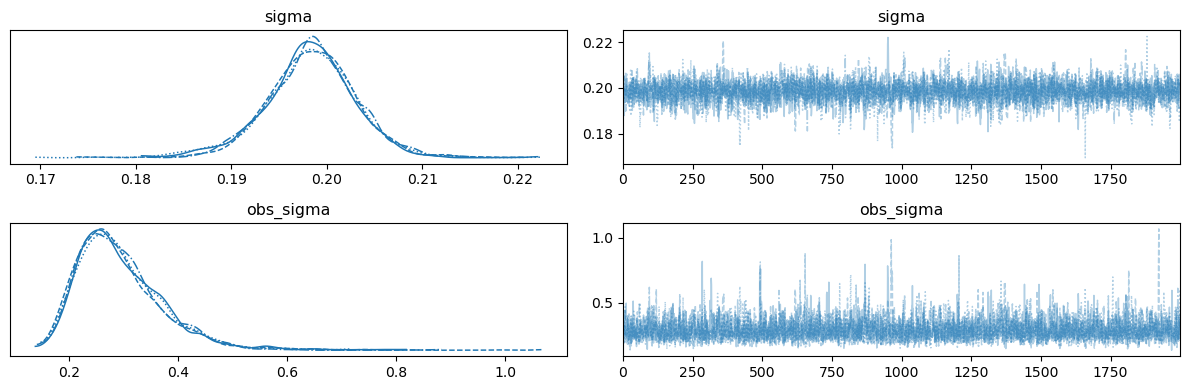

         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma  0.1984  0.0047  0.1894   0.2073     0.0001   0.0001  3657.361   

        ess_tail   r_hat  
sigma  2986.4756  1.0007  


In [4]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

S  = 100.0                    # spot
r  = 0.01                     # risk-free rate
T  = 0.5                      # time to maturity (yrs)
K  = np.linspace(80, 120, 10) # strikes
true_sigma = 0.20

from scipy.stats import norm
def bs_call_price_np(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

C_obs = bs_call_price_np(S, K, T, r, true_sigma)
C_obs += np.random.normal(0, 0.25, size=K.shape)

# ---------- Bayesian calibration ----------
with pm.Model() as model:

    K_data = pm.ConstantData("K_data", K)
    
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    obs_sigma = pm.HalfNormal("obs_sigma", sigma=0.5)
    
    def Phi(x):
        return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))
    
    # Black-Scholes call price computed symbolically
    d1 = (pm.math.log(S / K_data) + (r + 0.5 * sigma**2) * T) / (sigma * pm.math.sqrt(T))
    d2 = d1 - sigma * pm.math.sqrt(T)
    C_model = S * Phi(d1) - K_data * pm.math.exp(-r * T) * Phi(d2)
    
    # observation noise (learn it or fix it)

    pm.Normal("C_obs", mu=C_model, sigma=obs_sigma, observed=C_obs)
    
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.95, return_inferencedata=True)

# ---------- diagnostics ----------
az.plot_trace(trace)
plt.tight_layout(); plt.show()

print(az.summary(trace, var_names=["sigma"], round_to=4))


[*********************100%***********************]  2 of 2 completed
/var/folders/hm/1hdk35ys09q01dr03wnx7cn40000gn/T/ipykernel_20905/1488184721.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.dropna(inplace=True)
/var/folders/hm/1hdk35ys09q01dr03wnx7cn40000gn/T/ipykernel_20905/1488184721.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, theta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Estimated OU parameters:
μ = 7.3016, θ = 0.0057, σ = 0.3451


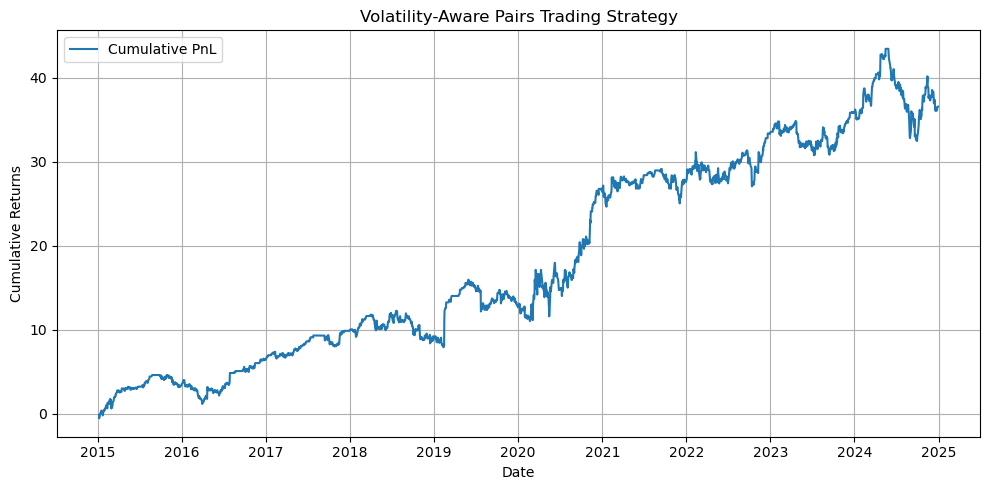

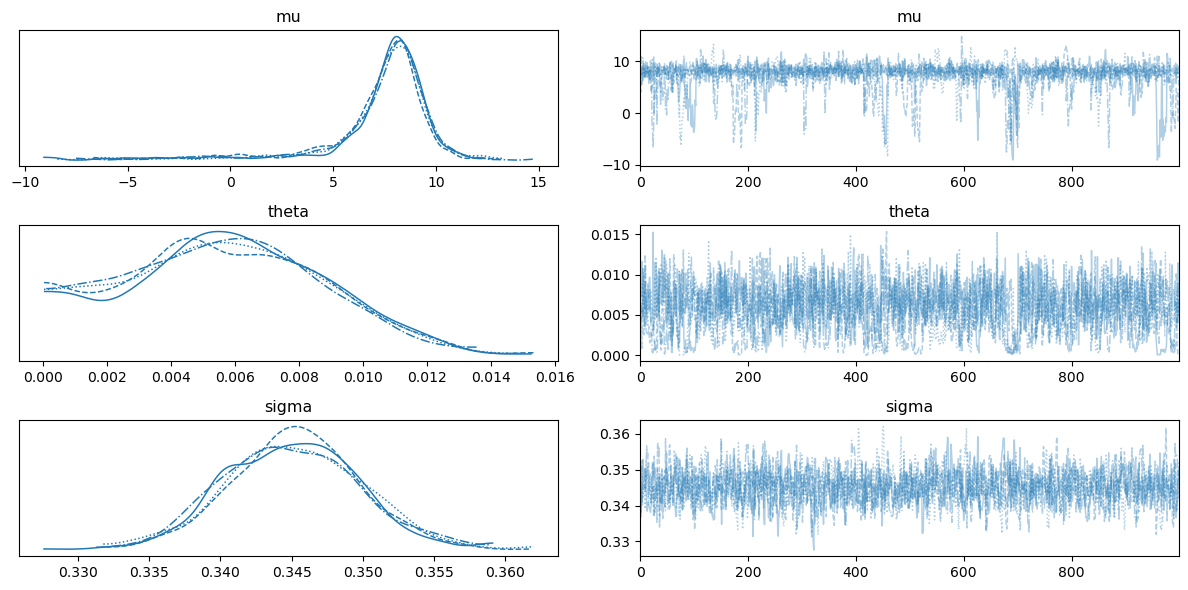

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az

# -------------------------
# 1. Load Historical Data Safely
# -------------------------
tickers = ['KO', 'PEP']  # Coca-Cola and Pepsi
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download price data with fallback
data = yf.download(tickers, start=start_date, end=end_date)

# Attempt to get 'Adj Close', fallback to 'Close'
try:
    prices = data['Adj Close']
except KeyError:
    print("WARNING: 'Adj Close' not found. Using 'Close' instead.")
    prices = data['Close']

prices.dropna(inplace=True)

# -------------------------
# 2. Hedge Ratio (OLS Regression)
# -------------------------
y = prices[tickers[0]]
x = prices[tickers[1]]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
hedge_ratio = model.params[1]
spread = y - hedge_ratio * prices[tickers[1]]

# -------------------------
# 3. Bayesian OU Inference
# -------------------------
returns = spread.diff().dropna()
spread_lag = spread.shift(1).dropna().loc[returns.index]

with pm.Model() as ou_model:
    # Register lagged spread as symbolic data
    pm_data_lag = pm.ConstantData("spread_lag", spread_lag.values)
    pm_data_ret = pm.ConstantData("returns", returns.values)

    mu = pm.Normal("mu", mu=0, sigma=5)
    theta = pm.HalfNormal("theta", sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    dt = 1.0
    expected_return = -theta * (pm_data_lag - mu) * dt

    pm.Normal("obs", mu=expected_return, sigma=sigma * np.sqrt(dt), observed=pm_data_ret)

    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


# -------------------------
# 4. Extract OU Parameters
# -------------------------
mu_post = trace.posterior["mu"].mean().item()
theta_post = trace.posterior["theta"].mean().item()
sigma_post = trace.posterior["sigma"].mean().item()

print(f"Estimated OU parameters:\nμ = {mu_post:.4f}, θ = {theta_post:.4f}, σ = {sigma_post:.4f}")

# -------------------------
# 5. Trading Rule (Z-score)
# -------------------------
z_score = (spread - mu_post) / sigma_post

long_signal = z_score < -1
short_signal = z_score > 1
exit_signal = (z_score > -0.2) & (z_score < 0.2)

position = np.zeros(len(spread))
position[long_signal] = 1
position[short_signal] = -1
position[exit_signal] = 0
position = pd.Series(position, index=spread.index).ffill().fillna(0)

returns = position.shift(1) * spread.diff()
cum_returns = returns.cumsum()

# -------------------------
# 6. Plot Results
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(cum_returns, label='Cumulative PnL')
plt.title("Volatility-Aware Pairs Trading Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# 7. Trace Diagnostics
# -------------------------
az.plot_trace(trace, var_names=["mu", "theta", "sigma"])
plt.tight_layout(); plt.show()


[*********************100%***********************]  2 of 2 completed
/var/folders/hm/1hdk35ys09q01dr03wnx7cn40000gn/T/ipykernel_20905/2097599251.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = data['MSFT'][-1]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 1 seconds.
/var/folders/hm/1hdk35ys09q01dr03wnx7cn40000gn/T/ipykernel_20905/2097599251.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol_gbm.fillna(method='bfill', inplace=True)


Estimated implied volatility (BS calibration): 0.2000


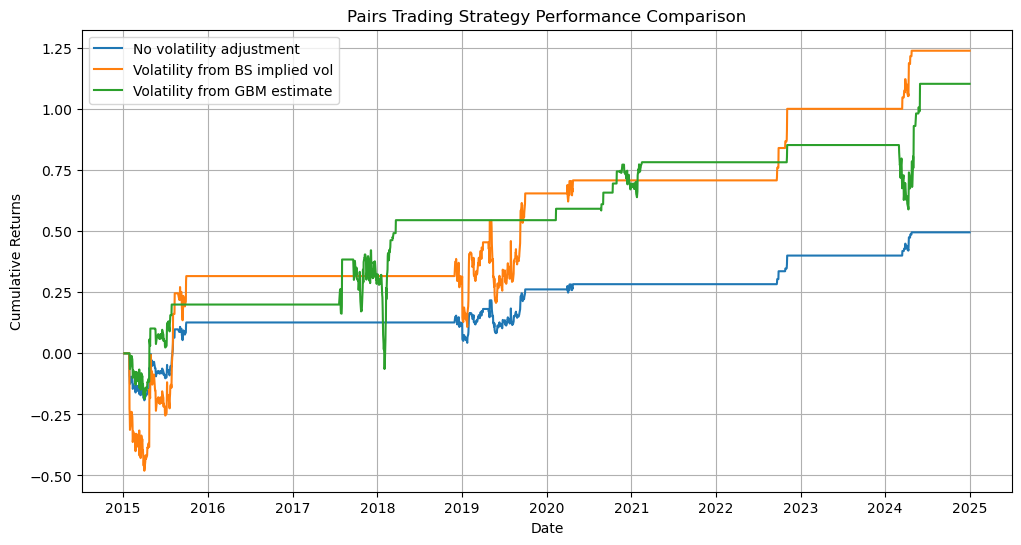

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- 1. Download stock data ---
tickers = ['MSFT', 'AAPL']
start_date = '2015-01-01'
end_date = '2024-12-31'
data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()

log_prices = np.log(data)

# --- 2. Synthetic option prices for implied volatility estimation ---
# (for demo: simulate call prices on MSFT at T=0.5 years)

S = data['MSFT'][-1]
r = 0.01
T = 0.5
strikes = np.linspace(S * 0.8, S * 1.2, 10)
true_sigma = 0.2

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

C_true = bs_call_price(S, strikes, T, r, true_sigma)
C_obs = C_true + np.random.normal(0, 0.25, size=len(strikes))  # noisy option prices

# --- 3. Bayesian inference of implied volatility from option prices ---
with pm.Model() as bs_model:
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    
    def Phi(x):
        return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))
    
    d1 = (pm.math.log(S / strikes) + (r + 0.5 * sigma**2) * T) / (sigma * pm.math.sqrt(T))
    d2 = d1 - sigma * pm.math.sqrt(T)
    C_model = S * Phi(d1) - strikes * pm.math.exp(-r * T) * Phi(d2)
    
    pm.Normal('obs', mu=C_model, sigma=0.25, observed=C_obs)
    trace_bs = pm.sample(1500, tune=1500, target_accept=0.95, progressbar=False, return_inferencedata=True)

sigma_imp = trace_bs.posterior['sigma'].mean().item()
print(f"Estimated implied volatility (BS calibration): {sigma_imp:.4f}")

# --- 4. Estimate GBM volatility of stocks ---
returns = log_prices.diff().dropna()
vol_gbm = returns.rolling(window=252).std() * np.sqrt(252)  # annualized volatility
vol_gbm.fillna(method='bfill', inplace=True)

# --- 5. Define function to run pairs trading strategy ---
def pairs_trading_strategy(log_prices, vol_adj=None, entry_thresh=1.5, exit_thresh=0.5):
    # Compute spread and spread returns
    spread = log_prices[tickers[0]] - log_prices[tickers[1]]
    
    # Adjust spread by volatility if provided
    if vol_adj is not None:
        # For example, normalize spread by combined vol
        combined_vol = vol_adj[tickers[0]] + vol_adj[tickers[1]]
        spread = spread / combined_vol
    
    mu = spread.mean()
    sigma = spread.std()
    z_score = (spread - mu) / sigma
    
    positions = pd.Series(0, index=spread.index)
    positions[z_score > entry_thresh] = -1
    positions[z_score < -entry_thresh] = 1
    positions[np.abs(z_score) < exit_thresh] = 0
    positions = positions.ffill().shift(1).fillna(0)
    
    spread_returns = spread.diff()
    strategy_returns = positions * spread_returns
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns

# --- 6. Run all 3 scenarios ---
# Scenario 1: Ignore implied volatility
ret1 = pairs_trading_strategy(log_prices)

# Scenario 2: Use implied volatility from BS calibration (apply same sigma to both stocks for simplicity)
vol_imp = pd.DataFrame(index=log_prices.index, columns=tickers, data=sigma_imp)
ret2 = pairs_trading_strategy(log_prices, vol_adj=vol_imp)

# Scenario 3: Use GBM volatility (rolling annualized vol)
ret3 = pairs_trading_strategy(log_prices, vol_adj=vol_gbm)

# --- 7. Plot results ---
plt.figure(figsize=(12,6))
plt.plot(ret1, label='No volatility adjustment')
plt.plot(ret2, label='Volatility from BS implied vol')
plt.plot(ret3, label='Volatility from GBM estimate')
plt.title('Pairs Trading Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


Performance without volatility adjustment: {'Sharpe': 1.96872492694046, 'Cumulative Return': 0.1118068154731755, 'Max Drawdown': -0.025903851710814885}
Performance with volatility adjustment: {'Sharpe': 0.41327481038231967, 'Cumulative Return': 0.015496336062999827, 'Max Drawdown': -0.025724263062453345}


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


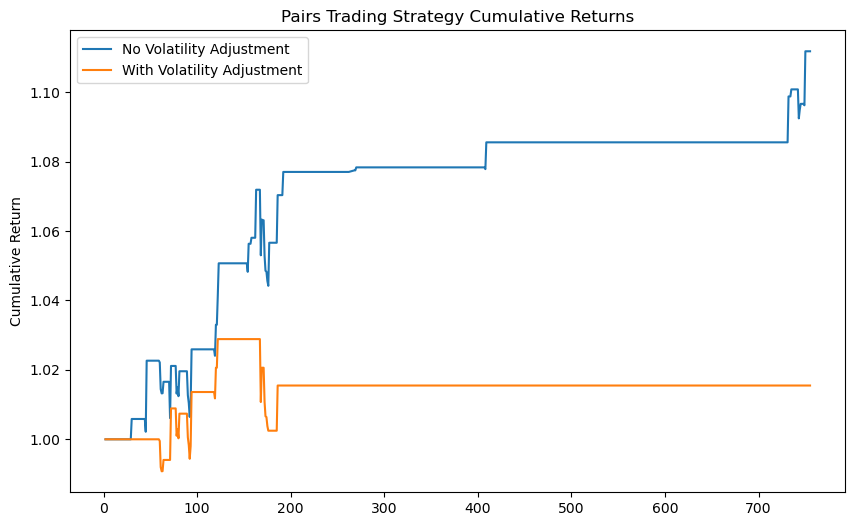

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Simulate correlated GBM price series ---

def simulate_gbm_pair(T=252*3, mu=0.05, sigma=0.2, rho=0.8, S0=100):
    dt = 1/252
    cov = np.array([[sigma**2, rho*sigma**2], [rho*sigma**2, sigma**2]])  # convert to np.array
    cov = cov * dt  # now this works
    returns = np.random.multivariate_normal([mu*dt, mu*dt], cov, size=T)
    logS = np.log(S0) + returns.cumsum(axis=0)
    prices = np.exp(logS)
    return pd.DataFrame(prices, columns=["Stock_A", "Stock_B"])

prices = simulate_gbm_pair()

# --- Compute spread (price difference) and rolling volatility ---
spread = prices["Stock_A"] - prices["Stock_B"]
log_returns_spread = np.log(spread).diff().dropna()  # log returns of spread
rolling_vol = log_returns_spread.rolling(window=20).std()  # 20-day rolling vol

# For simplicity avoid NaNs by aligning indices
spread = spread.loc[rolling_vol.index]

# --- Simple pairs trading strategy ---
def pairs_strategy(spread, rolling_vol=None, vol_adjust=False, k=1.5):
    mean_spread = spread.rolling(window=20).mean()
    std_spread = spread.rolling(window=20).std()
    
    signals = pd.Series(0, index=spread.index)
    upper = mean_spread + (k * std_spread)
    lower = mean_spread - (k * std_spread)
    
    # Adjust thresholds by volatility if requested
    if vol_adjust and rolling_vol is not None:
        upper += rolling_vol * std_spread.mean()
        lower -= rolling_vol * std_spread.mean()
    
    # Generate signals: 1 = long spread, -1 = short spread
    signals[spread > upper] = -1
    signals[spread < lower] = 1
    signals = signals.fillna(0)
    
    return signals

# Get signals for both cases
signals_no_vol = pairs_strategy(spread, vol_adjust=False)
signals_vol = pairs_strategy(spread, rolling_vol=rolling_vol, vol_adjust=True)

# --- Backtest ---
def backtest(prices, signals):
    # Assume hedge ratio = 1 for simplicity
    ret_A = prices["Stock_A"].pct_change().loc[signals.index]
    ret_B = prices["Stock_B"].pct_change().loc[signals.index]
    
    # Strategy return = long A and short B if signal = 1, vice versa if -1
    strat_returns = signals.shift(1) * (ret_A - ret_B)
    strat_returns = strat_returns.fillna(0)
    return strat_returns

rets_no_vol = backtest(prices, signals_no_vol)
rets_vol = backtest(prices, signals_vol)

# --- Performance comparison ---
def performance_metrics(returns):
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cum_return = (1 + returns).cumprod().iloc[-1] - 1
    max_dd = (returns.cumsum() - returns.cumsum().cummax()).min()
    return {"Sharpe": sharpe, "Cumulative Return": cum_return, "Max Drawdown": max_dd}

perf_no_vol = performance_metrics(rets_no_vol)
perf_vol = performance_metrics(rets_vol)

print("Performance without volatility adjustment:", perf_no_vol)
print("Performance with volatility adjustment:", perf_vol)

# --- Plot cumulative returns ---
plt.figure(figsize=(10,6))
(1 + rets_no_vol).cumprod().plot(label="No Volatility Adjustment")
(1 + rets_vol).cumprod().plot(label="With Volatility Adjustment")
plt.title("Pairs Trading Strategy Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


[*********************100%***********************]  2 of 2 completed
Initializing NUTS using jitter+adapt_diag...


Estimating volatility for PEP...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


Estimating volatility for KO...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Estimated volatility (PEP): 0.0120
Estimated volatility (KO): 0.0110
Performance WITHOUT volatility adjustment: {'Sharpe': -0.11094212828116641, 'Cumulative Return': -1.0000000582670838, 'Max Drawdown': -810.817933980319}
Performance WITH volatility adjustment: {'Sharpe': -0.11332155665972785, 'Cumulative Return': -1.000000000000847, 'Max Drawdown': -809.3194774675343}


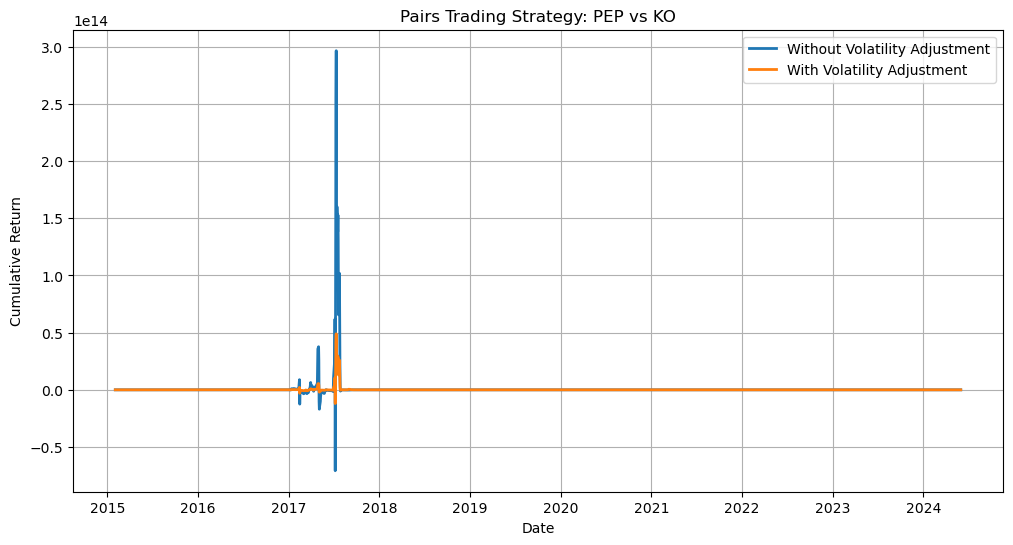

In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 1. Download daily adjusted close prices for Pepsi and Coca-Cola
tickers = ["PEP", "KO"]
data = yf.download(tickers, start="2015-01-01", end="2024-06-01")["Close"].dropna()

# 2. Compute daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

# 3. Bayesian inference to estimate volatility sigma of GBM for each stock
def estimate_volatility(log_ret):
    with pm.Model() as model:
        sigma = pm.HalfNormal("sigma", sigma=1)
        mu = pm.Normal("mu", mu=0, sigma=1)
        obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_ret.values)
        trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95, progressbar=False)
    return trace

print("Estimating volatility for PEP...")
trace_pep = estimate_volatility(log_returns["PEP"])
print("Estimating volatility for KO...")
trace_ko = estimate_volatility(log_returns["KO"])

sigma_pep = az.summary(trace_pep, var_names=["sigma"])["mean"].values[0]
sigma_ko = az.summary(trace_ko, var_names=["sigma"])["mean"].values[0]

print(f"Estimated volatility (PEP): {sigma_pep:.4f}")
print(f"Estimated volatility (KO): {sigma_ko:.4f}")

# 4. Prepare the pairs trading strategy

window = 20  # rolling window size

# Compute hedge ratio by rolling linear regression
def rolling_hedge_ratio(prices, window):
    hedge_ratios = []
    for i in range(window, len(prices)):
        X = prices["KO"].iloc[i-window:i].values.reshape(-1,1)
        y = prices["PEP"].iloc[i-window:i].values
        model = LinearRegression().fit(X, y)
        hedge_ratios.append(model.coef_[0])
    hedge_ratios = [hedge_ratios[0]]*window + hedge_ratios
    return pd.Series(hedge_ratios, index=prices.index)

hedge_ratios = rolling_hedge_ratio(data, window)

# Calculate adjusted spread
adj_spread = data["PEP"] - hedge_ratios * data["KO"]

# Rolling z-score on adjusted spread
z_score = (adj_spread - adj_spread.rolling(window).mean()) / adj_spread.rolling(window).std()

# Volatility adjustment factor (scale factor to control impact of volatility)
vol_scale = 2.0

# Use the Bayesian inferred volatilities to create a combined volatility signal
vol_signal = vol_scale * (sigma_pep + sigma_ko) / 2

# Signals for trading
signal_no_vol = - z_score
signal_vol = - (z_score + vol_signal)

# Compute daily returns of the spread (log returns of adjusted spread)
spread_returns = adj_spread.pct_change().fillna(0)

# Calculate strategy returns
rets_no_vol = signal_no_vol.shift(1) * spread_returns
rets_vol = signal_vol.shift(1) * spread_returns

# Clean NaNs after shift
rets_no_vol = rets_no_vol.dropna()
rets_vol = rets_vol.dropna()

# Performance metrics
def performance_metrics(returns):
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cum_return = (1 + returns).cumprod().iloc[-1] - 1
    max_dd = (returns.cumsum() - returns.cumsum().cummax()).min()
    return {"Sharpe": sharpe, "Cumulative Return": cum_return, "Max Drawdown": max_dd}

print("Performance WITHOUT volatility adjustment:", performance_metrics(rets_no_vol))
print("Performance WITH volatility adjustment:", performance_metrics(rets_vol))

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot((1 + rets_no_vol).cumprod() - 1, label="Without Volatility Adjustment", linewidth=2)
plt.plot((1 + rets_vol).cumprod() - 1, label="With Volatility Adjustment", linewidth=2)
plt.title("Pairs Trading Strategy: PEP vs KO")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma]
Sampling 1 chain for 1_000 tun

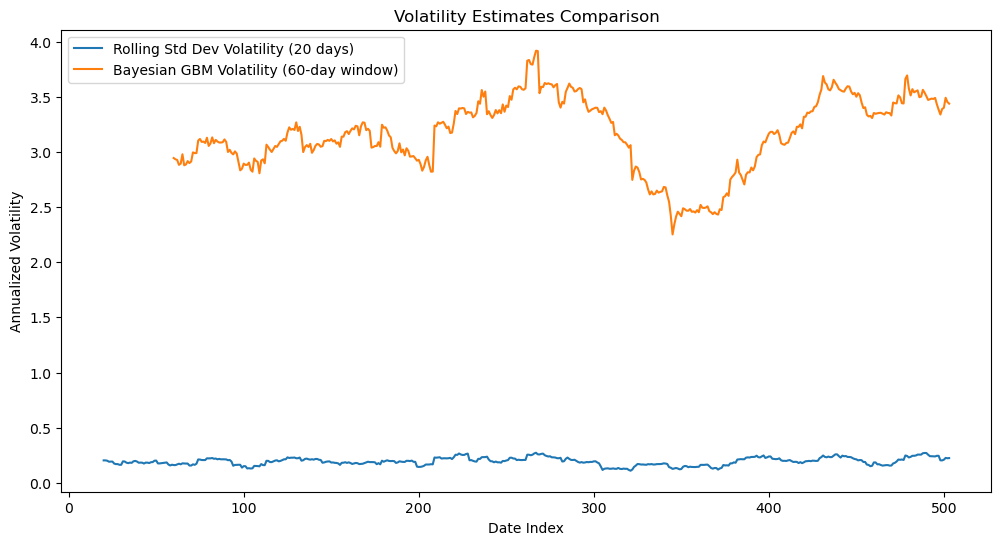

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# 1) Simulate example GBM stock price data for 2 years (approx 504 trading days)
np.random.seed(42)
T = 504
dt = 1/252
mu_true = 0.05
sigma_true = 0.2

# GBM log returns
log_returns = np.random.normal(loc=mu_true*dt, scale=sigma_true*np.sqrt(dt), size=T)
prices = 100 * np.exp(np.cumsum(log_returns))  # start price 100

prices = pd.Series(prices)

# 2) Calculate rolling volatility (20-day window, annualized)
rolling_window = 20
log_ret_series = np.log(prices / prices.shift(1)).dropna()
rolling_vol = log_ret_series.rolling(window=rolling_window).std() * np.sqrt(252)

# 3) Bayesian GBM volatility estimation on rolling windows
def bayesian_volatility_estimate(returns_window):
    with pm.Model() as model:
        mu = pm.Normal('mu', mu=0, sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        pm.Normal('obs', mu=mu*dt, sigma=sigma*np.sqrt(dt), observed=returns_window)
        trace = pm.sample(1000, tune=1000, cores=1, chains=1, progressbar=False, random_seed=42)
    return trace.posterior['sigma'].mean().item() * np.sqrt(252)

# Rolling Bayesian volatility (this is slow, so keep window and data size small)
bayes_vol = []
window_size = 60  # number of days in each MCMC window
for start in range(len(log_ret_series) - window_size + 1):
    sample_returns = log_ret_series.iloc[start:start+window_size].values
    vol_estimate = bayesian_volatility_estimate(sample_returns)
    bayes_vol.append(vol_estimate)

# Align the Bayesian volatility series with the rolling volatility
bayes_vol_series = pd.Series(bayes_vol, index=log_ret_series.index[window_size-1:])

# 4) Plot results
plt.figure(figsize=(12,6))
plt.plot(rolling_vol, label='Rolling Std Dev Volatility (20 days)')
plt.plot(bayes_vol_series, label='Bayesian GBM Volatility (60-day window)')
plt.title('Volatility Estimates Comparison')
plt.xlabel('Date Index')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.show()
